In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import os
import ast


## <span style="color:Gold">**1: Data Pipelining / Visualization Project**</span>

### <span style="color:Grey "> *Your objective is to perform:* </span>
+ data engineering
+ data cleaning
+ data transformation 

<span style="color:Grey "> on the provided raw data files to create meaningful CSV files that represent database tables: </span>

- for players 
- teams
- play-by-play actions

<span style="color:Grey "> Additionally, you will create visualizations and perform data analysis on the play-by-play data to gain insights into the Indiana Pacers' performance during the three-game span. </span>

<span style="color:Gold"> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - </span>



### <span style="color:Grey "> *Data Files:* </span>
<span style="color:Grey "> Play-by-Play (PBP) CSV Data Files: </span>

- These files contain the detailed play-by-play data for each of the three games played by the Indiana Pacers. 
- The data includes information such as the action type, game clock, period, ROSTERS involved, etc.

<span style="color:Grey "> Rosters JSON Data Files:  </span>

- These JSON files contain the rosters for each of the three games. 
- Each roster includes the list of ROSTERS participating in the respective game, along with their unique identifiers, full names, jersey numbers, etc.

<span style="color:Grey "> Teams JSON Data File:   </span>
- This JSON file contains information about all teams in the NBA. 
- Each entry represents a team and includes details such as the team's unique identifier, name, city, tricode, division, conference, status, and timezone.

<span style="color:Gold"> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - </span>


### <span style="color:Grey "> *Data Engineering Objective:* </span>

Candidates are required to use Python programming languages to complete the data engineering tasks. 

They should leverage appropriate libraries and tools available in Python to efficiently handle data cleaning, transformation, and CSV export tasks.
 
<span style="color:Grey "> Data Cleaning and Transformation:</span>
- Clean the data by handling missing values and standardizing data formats.
- Perform data transformation as needed to ensure data consistency and accuracy.

<span style="color:Grey "> Create Database Tables: From the cleaned data, create the following three database tables:</span>




<span style="color:Gold"> _____________________</span>

<span style="color:Grey ">  Players Table: </span>


This table should contain information about individual players, including their unique identifiers, full names, jersey numbers, etc.


In [2]:
# Extract Roster Files.


roster_160 = pd.read_json('Raw_Data/0022200160_roster.json')
roster_187 = pd.read_json('Raw_Data/0022200187_roster.json')
roster_211 = pd.read_json('Raw_Data/0022200211_roster.json')

rosters_list = [roster_160,roster_187, roster_211]

In [3]:
# Function:
#   - rename duplicate columns
#   - add columns to MAIN_DF/EXTRACT_DF
#   + used as replacement for concat when None values are prefered over NaN

def format_df(MAIN_DF, EXTRACT_DF):
    # ----------------------
    # Find duplicate columns
    cols_dups = EXTRACT_DF.columns.duplicated()
    cols_dups = [EXTRACT_DF.columns[i] for i in range(len(EXTRACT_DF.columns)) if cols_dups[i]]
    # Rename duplicate columns
    cols = []
    i = 1
    for column in EXTRACT_DF.columns:
        if column in cols_dups:
            cols.append(column + f'_{i}')
            i +=1
            # continue
        else:
            cols.append(column)
    # print(cols)
    EXTRACT_DF.columns = cols

    # ----------------------
    # Add columns to MAIN_DF/EXTRACT_DF if needed.
    # Defualt column values = NULL
    # Used when MAIN_DF has more columns then EXTRACT_DF OR EXTRACT_DF has new columns not in MAIN_DF

    if MAIN_DF.empty:
        # If MAIN_DF is empty MAIN_DF = EXTRACT_DF
        pass
    else:
        # Validate that all columns in MAIN_DF/EXTRACT_DF are in MAIN_DF/EXTRACT_DF
        new_columns_EXTRACT = [x for x in EXTRACT_DF.columns.to_list() if x not in MAIN_DF.columns.to_list()]
        new_columns_MAIN = [x for x in MAIN_DF.columns.to_list() if x not in EXTRACT_DF.columns.to_list()]

        if len(new_columns_MAIN) == 0 and len(new_columns_EXTRACT) == 0:
            pass
        else:
            for column in new_columns_EXTRACT:
                MAIN_DF[column] = None                   
            for column in new_columns_MAIN:
                EXTRACT_DF[column] = None 

        EXTRACT_DF = EXTRACT_DF[MAIN_DF.columns]

    return EXTRACT_DF


In [4]:
# FUNCTION: Extract players/staff information from team information.

def extract_team(gameId_df,team_info,team_extract_players):
    players_df = pd.DataFrame()

    for player in team_extract_players:

        player_df = pd.json_normalize(player)
        player_df = pd.concat([gameId_df,team_info,player_df],axis = 1)

        player_df = format_df(players_df, player_df)
        players_df = pd.concat([players_df,player_df], ignore_index = True)
    
    players_df.columns = player_df.columns
    players_df = players_df.replace('', None)

    return players_df

In [5]:
# FUNCTION: Extract team information from roster file. Make databases for each assocaited team.

def roster_extract(roster):
    awayTeam = roster.iloc[0,0]
    gameId = roster.iloc[1,0]
    homeTeam = roster.iloc[2,0]
    gameId_df = pd.DataFrame([gameId], columns = ['gameId'])

    home_team = pd.json_normalize(homeTeam)
    home_team_players = home_team.iloc[0,5]
    home_team_staff = home_team.iloc[0,6]

    away_team = pd.json_normalize(awayTeam)
    away_team_players = away_team.iloc[0,5]
    away_team_staff = away_team.iloc[0,6]

    # Isolate genral information for all players/staff.
    home_team = home_team[['teamId','teamName','teamCity','teamTricode','status']]
    home_team_players_df = extract_team(gameId_df,home_team,home_team_players)
    home_team_staff_df = extract_team(gameId_df,home_team,home_team_staff)
    home_team_staff_df = home_team_staff_df.rename(columns = {'teamId':'teamId_1', 'status':'status_2'})
    # Note: pd.concat gave NaN values vs format_dfs None values.
    home_team_staff_df = format_df(home_team_players_df, home_team_staff_df)


    away_team = away_team[['teamId','teamName','teamCity','teamTricode','status']]
    away_team_players_df = extract_team(gameId_df,away_team,away_team_players)
    away_team_staff_df = extract_team(gameId_df,away_team,away_team_staff)
    away_team_staff_df = away_team_staff_df.rename(columns = {'teamId':'teamId_1', 'status':'status_2'})
    # Note: pd.concat gave NaN values vs format_dfs None values.
    away_team_staff_df = format_df(away_team_players_df, away_team_staff_df)

    full_rosters = pd.concat([home_team_players_df,home_team_staff_df,away_team_players_df,away_team_staff_df], ignore_index= True)

    print('Database for Game ' + gameId + ':\nHome Team - ' + home_team.iloc[0,1] + ' | Away Team - ' + away_team.iloc[0,1] + '\n')

    return full_rosters

In [6]:
# FUNCTION: Extract roster information for all rosters in list.
def extract_all_rosters(roster_list):
    fullgame_rosters_df = pd.DataFrame()
    for roster in rosters_list:
        fullgame_rosters = roster_extract(roster)
        fullgame_rosters_df = pd.concat([fullgame_rosters_df,fullgame_rosters], ignore_index= True)
        fullgame_rosters_df.columns = fullgame_rosters.columns
    
    # Set paths for Databases
    players_database_path = str("Databases/PlayersTable/")
    os.makedirs(players_database_path, exist_ok = True)
    fullgame_rosters_df.to_csv(str(players_database_path + "PlayersDatabase.csv"), index=False)


    # display(fullgame_rosters_df)

In [7]:
extract_all_rosters(rosters_list)

Database for Game 0022200160:
Home Team - Pacers | Away Team - Nuggets

Database for Game 0022200187:
Home Team - Pacers | Away Team - Raptors

Database for Game 0022200211:
Home Team - Hornets | Away Team - Pacers



<span style="color:Gold"> _____________________</span>

<span style="color:Grey ">  Teams Table: </span>


This table should contain information about the teams involved in the game, including their unique identifiers, team names, tricodes, divisions, conferences, and other relevant details.

In [8]:
# Extract Team File.
teams = pd.read_json('Raw_Data/teams.json')

teams_df = pd.DataFrame()
for i in range(teams.shape[0]):
    team_df = pd.json_normalize(teams.iloc[i,0])
    teams_df = pd.concat([teams_df,team_df], ignore_index=True)
    teams_df.columns = team_df.columns

# Set paths for Databases
teams_path = str("Databases/Teams/")

os.makedirs(teams_path, exist_ok = True)
teams_df.to_csv(str(teams_path + "Teams.csv"), index=False)

print('Databases for Teams made.')


Databases for Teams made.


<span style="color:Gold"> _____________________</span>

<span style="color:Grey "> PBP (Play-by-Play) Table: </span>


This table should represent the play-by-play actions in the game, with relevant information such as the action type, game clock, period, players involved, etc.

In [9]:
# Extract PBP Files.

play_by_play_160 = pd.read_csv('Raw_Data/0022200160_pbp.csv')
play_by_play_187 = pd.read_csv('Raw_Data/0022200187_pbp.csv')
play_by_play_211 = pd.read_csv('Raw_Data/0022200211_pbp.csv')

pbp_list = [play_by_play_160,play_by_play_187,play_by_play_211]

In [10]:
# FUNCTION: Extract players from JSON format to DF.

def player_extract(players, team):
    players_df = pd.DataFrame()
    j = 0
    for player in players:
        player_df = pd.json_normalize(player)
        player_df.columns  = [team + '_player' + str(j) + '_personId', team + '_player' + str(j) + '_name', team + '_player' + str(j) + '_nameI', team + '_player' + str(j) + '_firstName', team + '_player' + str(j) + '_familyName']
        players_df = pd.concat([players_df,player_df], axis = 1, ignore_index = False)
        players_df = players_df.dropna(axis='columns')
        j += 1
    
    return players_df

In [11]:
# FUNCTION: Format player (JSON to DF) extract.

def extract_players_df (df, team):
    players_df = pd.DataFrame()
    for i in range(df.shape[0]):
        players = df.iloc[i,0]

        if players is None:
            players = pd.DataFrame([None])
        else:
            players = player_extract(players, team)

        if 'playersPlusMinus' in team:
            players = format_df(players_df, players)
        else:
            pass

        players_df = pd.concat([players_df,players], ignore_index= True)
        players_df.columns = players.columns


    if 0 in players_df.columns:
        players_df = players_df.drop(columns = [0])
    else:
        pass

    return players_df

In [12]:
# FUNCTION: Extract PBP information from PBP file.

def pbp_extract(pbp):
    actions_df = pd.DataFrame()
    total_actions_df = pd.DataFrame()
    for i in range(pbp.shape[0]):
        i_action_df = pd.DataFrame()

        i_action = pbp.iloc[i,1]
        i_action = ast.literal_eval(i_action)
        i_action_df = pd.json_normalize(i_action)
        gameId =  pbp.iloc[i,0]
        gameId_df = pd.DataFrame([gameId], columns = ['gameId'])
        
        i_action_df = pd.concat([gameId_df,i_action_df], axis = 1)
        i_action_df = format_df(actions_df, i_action_df)


        actions_df = pd.concat([actions_df,i_action_df], ignore_index= True)
        actions_df.columns = i_action_df.columns

        gameId = str(pbp.iloc[i,0])



    home_players_json_df = pd.DataFrame(actions_df.loc[:]['playersHome'])
    home_players_df = extract_players_df(home_players_json_df, 'home')

    away_players_json_df = pd.DataFrame(actions_df.loc[:]['playersAway'])
    away_players_df = extract_players_df(away_players_json_df, 'away')


    playersPlusMinusHome_json_df = pd.DataFrame(actions_df.loc[:]['playersPlusMinusHome'])
    playersPlusMinusHome_df = extract_players_df(playersPlusMinusHome_json_df, 'playersPlusMinus_home')

    playersPlusMinusAway_json_df = pd.DataFrame(actions_df.loc[:]['playersPlusMinusAway'])
    playersPlusMinusAway_df = extract_players_df(playersPlusMinusAway_json_df, 'playersPlusMinus_away')


    actions_df = actions_df.drop(columns = ['playersHome','playersAway', 'playersPlusMinusHome', 'playersPlusMinusAway'])
    total_actions_df = pd.concat([actions_df,home_players_df,away_players_df, playersPlusMinusHome_df,playersPlusMinusAway_df], axis = 1, ignore_index = False)

    
    print('Database for Game ' + gameId + ' PBP made.\nTotal columns: ' + str(len(total_actions_df.columns)) + '\n')

    return total_actions_df


In [13]:
# FUNCTION: Create database file with all PBPs.

def extract_all_pbp(pbp_list):
    all_pbps_df = pd.DataFrame()
    for pbp in pbp_list:
        total_actions_df = pbp_extract(pbp)
        total_actions_df = format_df(all_pbps_df, total_actions_df)
        all_pbps_df = pd.concat([all_pbps_df,total_actions_df], ignore_index= True)
        all_pbps_df.columns = total_actions_df.columns

    pbp_path = str("Databases/PBP/")
    os.makedirs(pbp_path, exist_ok = True)
    all_pbps_df.to_csv(str(pbp_path + "/PBP.csv"), index=False)

    return all_pbps_df

In [14]:
all_pbps_df = extract_all_pbp(pbp_list)

Database for Game 22200160 PBP made.
Total columns: 136

Database for Game 22200187 PBP made.
Total columns: 137

Database for Game 22200211 PBP made.
Total columns: 136



<span style="color:Gold"> _____________________</span>

<span style="color:Grey "> Export to CSV Files: </span>


- Export each of the created tables to separate CSV files to simulate database tables.


In [15]:
# Each database has been previously made.

<span style="color:Gold"> _____________________</span>

### <span style="color:Grey "> *Data Visualization and Reporting Objective:* </span>

<span style="color:Grey "> In either Python or R, use the following columns to recreate the ‘area’ column for action types ‘2pt’ and ‘3pt’ : </span>

- side
- x
- y
- shotDistance



<span style="color:Gold"> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - </span>

<span style="color:Grey ">  Once recreated, display a table that shows both teams values as two separate columns from each area: </span>
- for both rate (the percentage of shots from the area) 
- and efficiency (the percentage of shots made from the area) 

<span style="color:Gold"> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - </span>

<span style="color:Grey "> Additionally, display a simple visualization which showcases the Pacers total rate and efficiency values on a court for the 3 games selected. </span>

###### Below is a link to one of the official game’s shot charts to help guide you in recreating the data: 
https://www.nba.com/game/den-vs-ind-0022200160/game-charts?shotchart=shotzone. 

<span style="color:Gold"> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - </span>


In [16]:
# FUNCTION:
#   - Create shot rate/efficiency table for teams.
#   - Create shot rate/efficiency chart for teams. 


def area_stats(shots_df, teams_list,gameId):
    image = mpimg.imread('half_court.png')
    # fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
    fig, ax = plt.subplots(1,2, figsize=(15, 5))

    fig.suptitle('Game ID - ' + str(gameId))
    i = 0
    for team in teams_list:
        
        print(team)
        team_shots_df = shots_df[shots_df['teamTricode'] == team].reset_index(drop = True)
        # area_stats_df = area_stats(team_shots_df, team)

        cols = ['area', 'team', 'shot_rate', 'area_shot_efficiency']
        area_stats_df = pd.DataFrame(columns = cols)
        total_shots = team_shots_df.shape[0]

        areaType_list = team_shots_df['area'].unique()

        for area_type in areaType_list:
            
            area_types_df = shots_df[shots_df['area_recreated'] == area_type]

            total_area_shots = area_types_df.shape[0]
            area_shot_rate = round((total_area_shots/total_shots) * 100, 2)
            total_successful_area_shots = area_types_df['success'].astype('int').sum()
            area_efficiency = round((total_successful_area_shots/total_area_shots) * 100, 2)

            area_stats = pd.DataFrame([[area_type, team ,area_shot_rate, area_efficiency]], columns = cols)
            area_stats_df = pd.concat([area_stats_df, area_stats], ignore_index= True)
            area_stats_df.columns = cols
            
        display(area_stats_df)


        for area in area_stats_df.area.unique():
            ind_area_stats = area_stats_df[area_stats_df['area'] == area]
            shot_rate = ind_area_stats.iloc[0,2]
            shot_rate = str("SR: " + "{:.1%}".format(shot_rate/100))
            area_shot_eff = ind_area_stats.iloc[0,3]
            area_shot_eff = str("AE: " + "{:.1%}".format(area_shot_eff/100))

            if area == 'Restricted Area':
                ax[i].text(600, 1400, area, fontsize = 8, color = 'red')
                ax[i].text(600, 1450, shot_rate, fontsize = 6)
                ax[i].text(600, 1500, area_shot_eff, fontsize = 6)

                rectangleX = [540, 540, 1060, 1060, 540]
                rectangleY = [1350, 1600, 1600, 1350, 1350]
                ax[i].plot(rectangleX, rectangleY, '-', color = 'red')
            
            elif area == 'Left Corner 3':
                ax[i].text(1350, 750, area, fontsize = 6)
                ax[i].text(1375, 800, shot_rate, fontsize = 6)
                ax[i].text(1375, 850, area_shot_eff, fontsize = 6)
            
            elif area == 'Right Corner 3':
                ax[i].text(50, 750, area, fontsize = 6, color = 'gold')
                ax[i].text(50, 800, shot_rate, fontsize = 6)
                ax[i].text(50, 850, area_shot_eff, fontsize = 6)
            
            elif area == 'In The Paint (Non-RA)':
                ax[i].text(600, 1200, area, fontsize = 7, color = 'purple')
                ax[i].text(600, 1250, shot_rate, fontsize = 6)
                ax[i].text(600, 1300, area_shot_eff, fontsize = 6)

            elif area == 'Above the Break 3':
                ax[i].text(600, 400, area, fontsize = 8, color = 'green')
                ax[i].text(600, 450, shot_rate, fontsize = 6)
                ax[i].text(600, 500, area_shot_eff, fontsize = 6)

            elif area == 'Mid-Range':
                ax[i].text(200, 1200, area, fontsize = 8, color = 'blue')
                ax[i].text(200, 1250, shot_rate, fontsize = 6)
                ax[i].text(200, 1300, area_shot_eff, fontsize = 6)

            else:
                pass

            ax[i].set_title(team  + ' Shot Rate | Area Efficiency')

        ax[i].imshow(image)
        i += 1

    fig.show()


    return area_stats_df


In [17]:
# Tool used for isolating values to recreate 'area' column.

# Full Court
# ax = plt.axes()
# ax.scatter(area_df['x'], area_df['y'] , c = area_df['area'].map(colors))
# plt.show()

# ax.scatter(area_df['x'], area_df['y'] , c = area_df['area_recreated'].map(colors))
# plt.show()


# Isolation Lines
# ax.plot([10, 10 ,10 ,10],[0, 20, 40 ,100])
# ax.plot([90, 90, 90, 90],[0, 20, 40 ,100])

# ax.plot([20, 20, 20, 20],[0, 20, 40 ,100])
# ax.plot([80, 80, 80, 80],[0, 20, 40 ,100])


# ax.plot([0, 20, 40 ,100],[60, 60, 60 ,60])
# ax.plot([0, 20, 40 ,100],[40, 40, 40 ,40])


# Three point lines
# ax.plot([15, 15 ,15 ,15],[0, 20, 40 ,100])
# ax.plot([85, 85 ,85 ,85],[0, 20, 40 ,100])

# ax.plot([0, 20, 40 ,100],[94, 94, 94 ,94])
# ax.plot([0, 20, 40 ,100],[5, 5, 5,5])


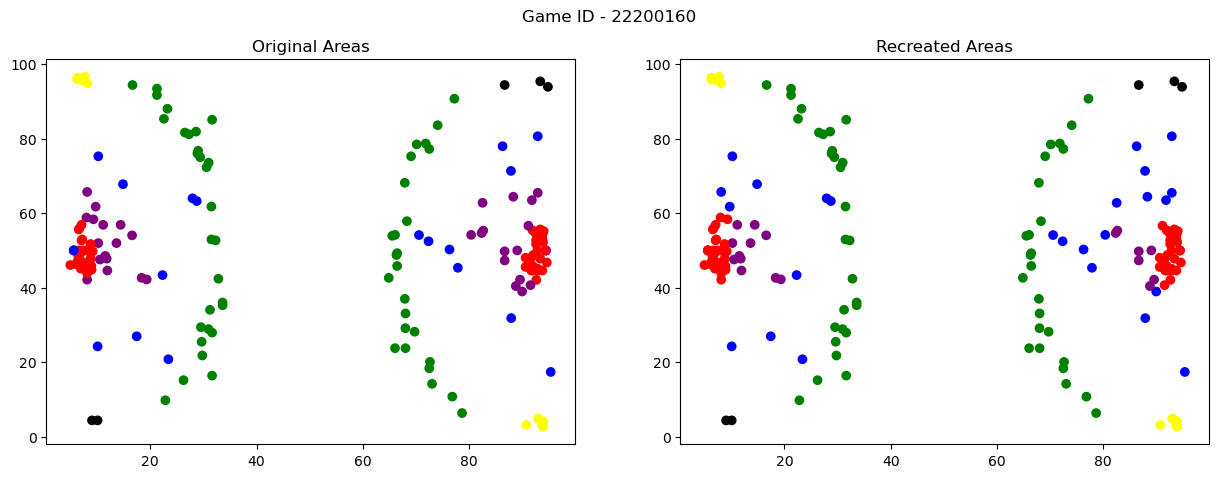

DEN


,area,team,shot_rate,area_shot_efficiency
0,Above the Break 3,DEN,61.36,33.33
1,Mid-Range,DEN,28.41,44.00
2,Restricted Area,DEN,80.68,57.75
3,In The Paint (Non-RA),DEN,20.45,55.56
4,Right Corner 3,DEN,5.68,40.00
5,Left Corner 3,DEN,12.50,54.55


IND


,area,team,shot_rate,area_shot_efficiency
0,Restricted Area,IND,73.96,57.75
1,Above the Break 3,IND,56.25,33.33
2,Left Corner 3,IND,11.46,54.55
3,Mid-Range,IND,26.04,44.00
4,In The Paint (Non-RA),IND,18.75,55.56
5,Right Corner 3,IND,5.21,40.00


----------------------------------------------


/var/folders/t_/4n8p8d1n181ftg5ns2231ydw0000gn/T/ipykernel_879/2025798826.py:90: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


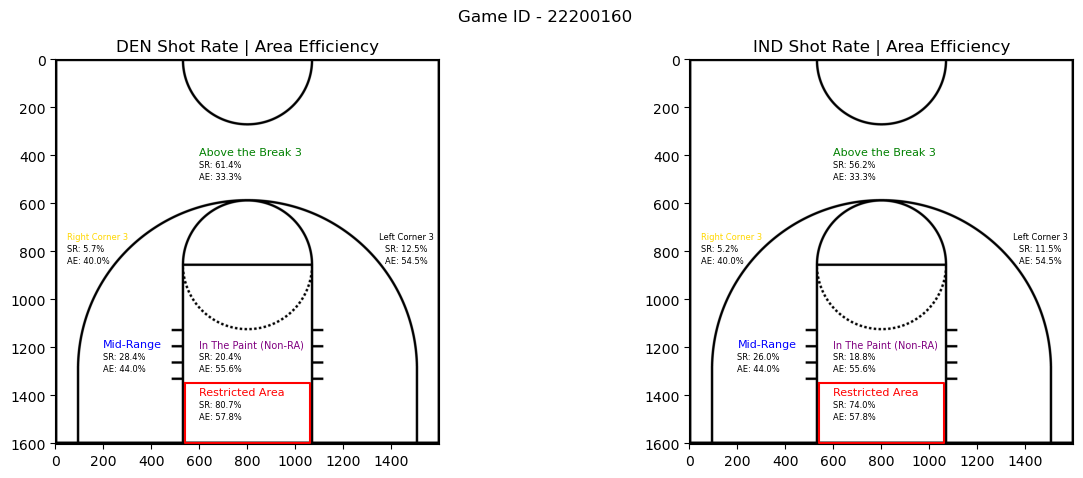

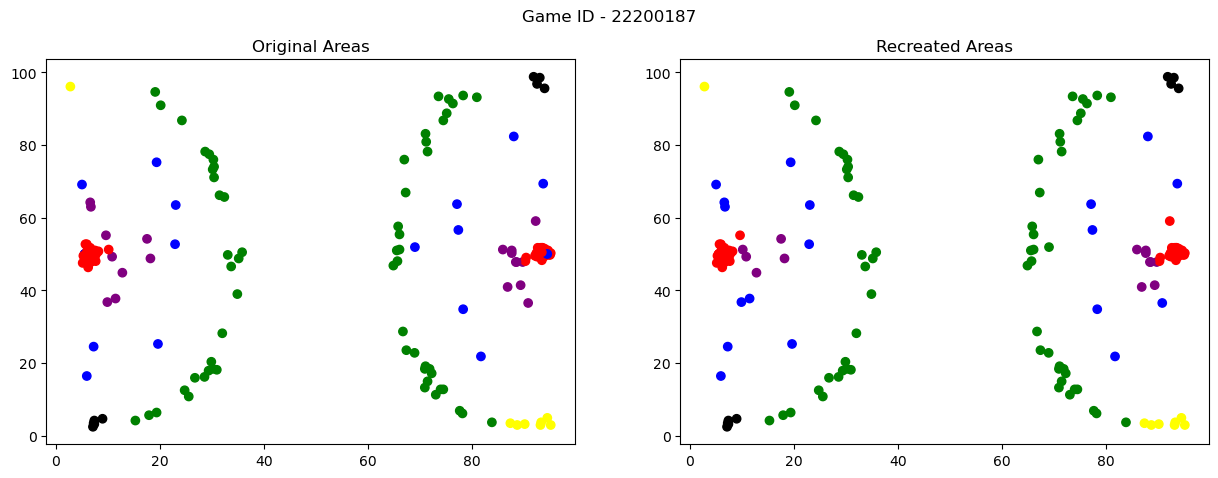

TOR


,area,team,shot_rate,area_shot_efficiency
0,In The Paint (Non-RA),TOR,13.83,53.85
1,Above the Break 3,TOR,65.96,32.26
2,Restricted Area,TOR,70.21,53.03
3,Right Corner 3,TOR,9.57,55.56
4,Mid-Range,TOR,19.15,55.56
5,Left Corner 3,TOR,8.51,12.50


IND


,area,team,shot_rate,area_shot_efficiency
0,Above the Break 3,IND,75.61,32.26
1,Restricted Area,IND,80.49,53.03
2,In The Paint (Non-RA),IND,15.85,53.85
3,Left Corner 3,IND,9.76,12.50
4,Mid-Range,IND,21.95,55.56
5,Right Corner 3,IND,10.98,55.56


----------------------------------------------


/var/folders/t_/4n8p8d1n181ftg5ns2231ydw0000gn/T/ipykernel_879/2025798826.py:90: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


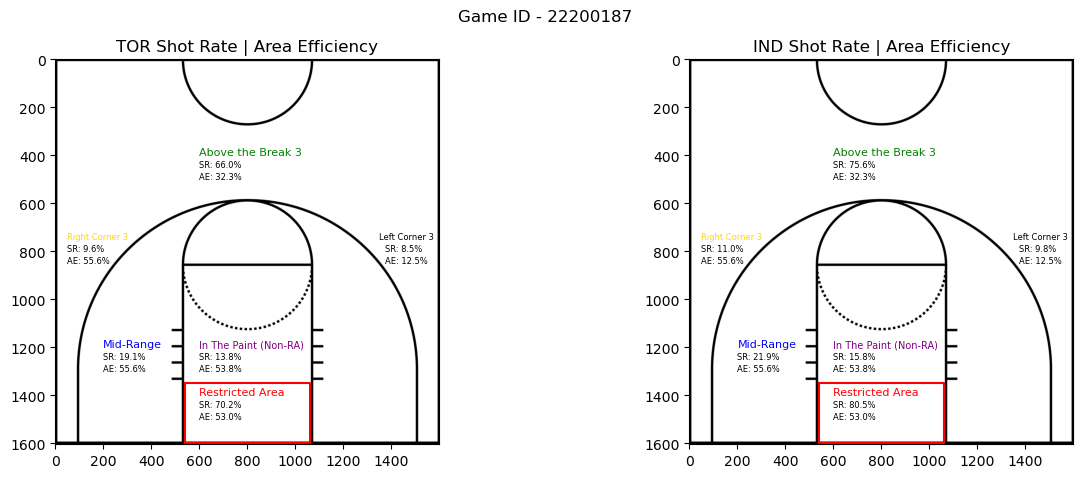

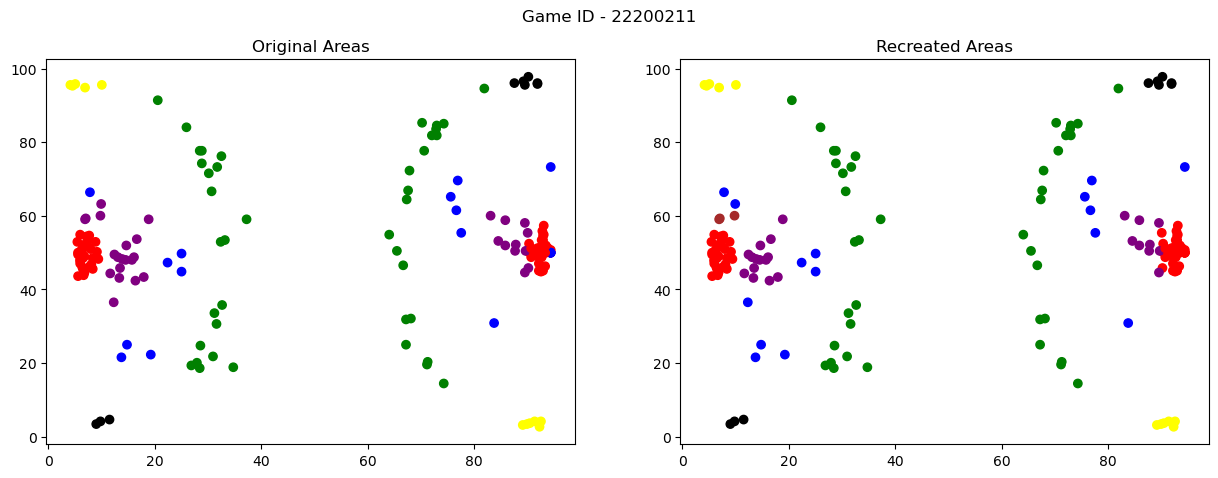

IND


,area,team,shot_rate,area_shot_efficiency
0,Restricted Area,IND,90.24,59.46
1,Above the Break 3,IND,50.00,39.02
2,Mid-Range,IND,18.29,46.67
3,In The Paint (Non-RA),IND,28.05,52.17
4,Left Corner 3,IND,13.41,27.27
5,Right Corner 3,IND,10.98,44.44


CHA


,area,team,shot_rate,area_shot_efficiency
0,Restricted Area,CHA,78.72,59.46
1,Above the Break 3,CHA,43.62,39.02
2,Mid-Range,CHA,15.96,46.67
3,Left Corner 3,CHA,11.70,27.27
4,In The Paint (Non-RA),CHA,24.47,52.17
5,Right Corner 3,CHA,9.57,44.44


----------------------------------------------


/var/folders/t_/4n8p8d1n181ftg5ns2231ydw0000gn/T/ipykernel_879/2025798826.py:90: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


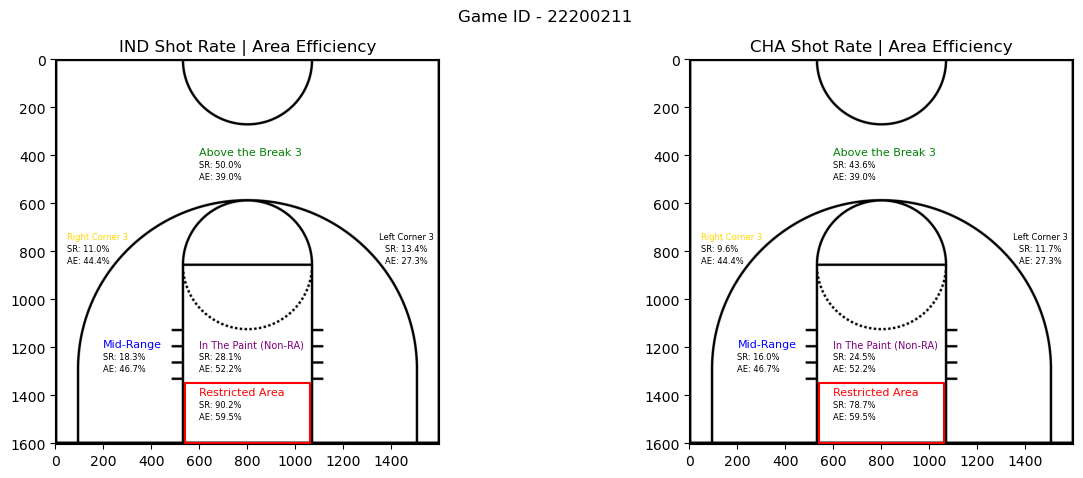

In [18]:
# - Recreate 'area' column: 'area_recreated' 
# - Plot shots for the three provided PBPs using a colormap derived from the 'area'/'area_recreated' columns. 


shots_df = all_pbps_df[((all_pbps_df['actionType'] ==  '3pt') | (all_pbps_df['actionType'] ==  '2pt'))].reset_index(drop = True)
shots_df['area_recreated'] = ''

# Define Recreated Areas
shots_df.loc[((shots_df['y'] > 93) & (shots_df['x'] < 15)) | ((shots_df['y'] < 5) & (shots_df['x'] > 85)),'area_recreated'] = 'Left Corner 3'
shots_df.loc[((shots_df['y'] < 5) & (shots_df['x'] < 15)) | ((shots_df['y'] > 93) & (shots_df['x'] > 85)),'area_recreated'] = 'Right Corner 3'
shots_df.loc[((shots_df['x'] > 15) & (shots_df['x'] < 84)) & (shots_df['shotDistance'] > 23.7) ,'area_recreated'] = 'Above the Break 3'

shots_df.loc[((shots_df['y'] < 65) & (shots_df['y'] > 35) & (shots_df['x'] > 10) & (shots_df['x'] < 20)) | ((shots_df['y'] < 65) & (shots_df['y'] > 35) & (shots_df['x'] < 90) & (shots_df['x'] > 80)),'area_recreated'] = 'In The Paint (Non-RA)'
shots_df.loc[((shots_df['y'] > 61) & (shots_df['y'] < 93) & (shots_df['shotDistance'] < 23.7)) | ((shots_df['y'] < 40) & (shots_df['y'] > 5) &(shots_df['shotDistance'] < 24)) | ((shots_df['x'] > 20) & (shots_df['x'] < 82)) & (shots_df['shotDistance'] < 23.7) ,'area_recreated'] = 'Mid-Range'
shots_df.loc[((shots_df['y'] < 59) & (shots_df['y'] > 40) & (shots_df['x'] < 10)) | ((shots_df['y'] < 60) & (shots_df['y'] > 40) & (shots_df['x'] > 90)),'area_recreated'] = 'Restricted Area'


for gameId in shots_df['gameId'].unique():
    shots = shots_df[shots_df['gameId'] == gameId]

    teams_list = shots['teamTricode'].unique()
    colors = {None:'white',  '':'brown', 'Restricted Area':'red', 'Above the Break 3':'green', 'Mid-Range':'blue', 'Left Corner 3':'yellow', 'In The Paint (Non-RA)':'purple','Right Corner 3':'black' }

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
    fig.suptitle('Game ID - ' + str(gameId))

    # Full Court
    ax1.scatter(shots['x'], shots['y'] , c = shots['area'].map(colors))
    ax1.set_title(str('Original Areas'))

    ax2.scatter(shots['x'], shots['y'] , c = shots['area_recreated'].map(colors))
    ax2.set_title('Recreated Areas')

    plt.show()

    area_stats_df = area_stats(shots,teams_list,gameId)

    print('----------------------------------------------')


### <span style="color:Grey "> *SQL Exercise Objective:* </span>

<span style="color:Grey "> In this SQL coding exercise, you will be given a task to retrieve information during a three-game span in November 2022:  </span>

- player information 
- the total number of assists made by each player

<span style="color:Grey "> You will need to write a sample SQL query to extract the required data from two tables you created above: </span>

- "pbp" (play-by-play actions) 
- "rosters" (player rosters).

<span style="color:Gold"> _____________________</span>

### <span style="color:Grey "> *Question:* </span>

<span style="color:Grey "> Write a SQL query to find:  </span>
- the names 
- and jersey numbers of all players who participated in the games for the Pacers. 
- display the total number of assists they made in each game


<span style="color:Grey "> If a player did not participate in a particular game, display “NULL” in the jersey number column and 0 assists for that game. </span>

<span style="color:Gold"> _____________________</span>

### <span style="color:Grey "> *SQL QUERY:* </span>

SELECT 

	DISTINCT ROSTERS.name, 
	ROSTERS.gameId, 
	MAX(CASE WHEN ROSTERS.name = PBP.name then ROSTERS.jerseyNum ELSE NULL END) jerseyNum,
	MAX(CASE WHEN ROSTERS.name = PBP.name then PBP.playerTotal ELSE 0 END) ASSISTS

FROM PLAYERS

	LEFT JOIN 
		(SELECT 
			PBP.name, 
			PBP.gameId, 
			PBP.actionType, 
			PBP.teamTricode, 
			MAX(PBP.playerTotal) as playerTotal 
		FROM PBP
		WHERE PBP.teamTricode = 'IND' AND PBP.actionType = 'assist'	
		GROUP BY PBP.name, PBP.gameId) PBP
		
ON ROSTERS.teamTricode = PBP.teamTricode and ROSTERS.gameId = PBP.gameId

WHERE ROSTERS.teamTricode = 'IND' AND ROSTERS.starter != ''

GROUP BY ROSTERS.name, ROSTERS.gameId;

<span style="color:Gold"> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - </span>

## <span style="color:Gold">**#2: Basketball Philosophical Question:**</span>


<span style="color:Grey "> What’s one coaching strategy or idea you’d recommend to a coaching staff? How would you communicate the idea? </span>



<span style="color:Gold"> _____________________</span>


Teams with a defensive-first mentality have a greater advantage during this era of the NBA. Being able to control the game through perfect defense helps increase the team's moral and opens up transition offense. A perfect roster for this idea would involve players in each position that are long, have speed, want to hustle, and have strength. Indiana's current roster only deficiency (for this strategy) is strength. Many of the guards are more offensively inclined. 
 

To communicate this idea/strategy for the upcoming season/seasons. I would first take a look at teams who have historically had a team built in a similar fashion. The team would have to be from 2010's to now, as today’s NBA defense is vastly different than previous decades. 
 
- Offensive/Defensive Schemes
    - Compare how their rosters looked vs Indiana's. 
        - If both rosters a similar, the same principles can be implemented/taught. 
        - If the rosters are vastly different more researched would be required.
            - This would first start by looking at the various rosters a coach/coaching staff has had and find players with similar traits. 
            
            
Finding this information would be a starting point for developing a defensive deck/module compiled of dashboards and film to showcase what the strategy's specific schemes can do and what role the players can play. Additionally, it would be interesting to develop some sort of simulation model on top of these findings to understand how any scheme changes would affect the flow of the game. 
 
 
- Changing the Roster
    - Find players who can fill the gaps of a defensive scheme.
        - As previously mentioned, Indiana's current deficiency for this strategy is strength. 
        - Simultaneously with gathering information on offensive/defensive schemes, I can compile player profiles for players who would be successful in these strategies. This would help find key players in the current market, upcoming free agency, or draft.
 

The player profiles would be a starting point for a second deck aimed to show players who could be successful in the strategy. 
 

 
Ultimately these decks/modules would be sent to the coaching staff and show how Indiana's current roster could do with a defensive-first strategy.

<span style="color:Gold"> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - </span>

Additionally with the technology currently being used, we could internally gather data to historically gauge biometrics of future players and how they could fit into similar systems.